# Import des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import KNNImputer

# Chargement des données

In [5]:
df = pd.read_csv("test_set.csv")

# Prévisualisation

In [ ]:
df

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock
0,0,1,vilnius,21,romanian,0,1,161,46
1,1,1,vilnius,21,romanian,0,1,187,32
2,2,1,vilnius,21,romanian,0,1,279,12
3,3,1,vilnius,21,romanian,0,1,395,10
4,4,1,vilnius,21,romanian,0,1,488,42
...,...,...,...,...,...,...,...,...,...
6639,6639,843,rome,5,irish,0,794,987,1
6640,6640,844,vienna,1,irish,1,794,26,1
6641,6641,844,vienna,1,irish,1,794,263,0
6642,6642,844,vienna,1,irish,1,794,456,0


# Etude des villes

Premièrement nous allons afficher la répartition des villes dans le dataset de test afin de vérifier si elles sont toutes présentes et de manière équitable.

In [ ]:
df["city"].value_counts()

amsterdam     1134
paris         1125
madrid        1094
copenhagen     723
rome           721
vilnius        609
vienna         568
sofia          374
valletta       296
Name: city, dtype: int64

Les villes sont effectivement toutes bien présentes mais de manière très déséquilibrée. Ce déséquilibre pourrait être retrouvé dans l'ensemble des données, ou pas. Pour avoir une idée de la réponse je vais utiliser des métadonnées associées aux villes qui pourraient expliquer le nombre d'hotêls que l'API renvoie pour celles-ci.

Dans un premier temps je vais vérifier si la répartition vue ci-dessus correspond à la taille des villes étudiées (en terme de nombre d'habitants).
Les données sont tirées du site : https://www.populationdata.net/palmares/villes/europe/

In [ ]:
population_data = {"amsterdam" : 2480394, "paris" : 13114718, "madrid" : 6475872, "copenhagen" : 2931445, "rome" : 4340474, "vilnius" : 673921, "vienna" : 2717459, "sofia" : 1681592, "valletta" : 408750}

Ensuite je suis allé extraire le nombre de recherches Google des termes "hotel" plus nom de la ville. J'ai stocké le nombre de résultats de la requête dans une liste (ordre = same que renvoyé par df["city"]).

In [ ]:
nb_url = [258, 705, 328, 69.5, 545, 11.8, 191, 225, 7.47] # unité = 10**6
# chiffres obtenus sur google.com langue = anglais US

J'ai également été sur le site https://www.booking.com/ et récupéré le nombre d'hôtel renvoyé pour une requête dans chaque ville (pas de dates et résa pour 2 adultes).

In [ ]:
data_booking = [1061, 4980, 3344, 475, 9029, 651, 2287, 971, 235]

Des données sur les pays peuvent également être retenues comme le PIB par habitant (à voir si c'est également utilisable pour la feature language).

In [ ]:
PIB = [48424, 38210, 26239, 58586, 31512, 18072, 45091, 8294, 27738]

In [ ]:
l = list(df["city"].value_counts())
df_city = pd.DataFrame(population_data.items(), columns=['city', 'nb_hab'])
df_city["nb_url"] = nb_url
df_city["booking"] = data_booking
df_city["PIB"] = PIB
df_city["nb_val"] = l

In [ ]:
df_city

,city,nb_hab,nb_url,booking,PIB,nb_val
0,amsterdam,2480394,258.00,1061,48424,1134
1,paris,13114718,705.00,4980,38210,1125
2,madrid,6475872,328.00,3344,26239,1094
3,copenhagen,2931445,69.50,475,58586,723
4,rome,4340474,545.00,9029,31512,721
5,vilnius,673921,11.80,651,18072,609
6,vienna,2717459,191.00,2287,45091,568
7,sofia,1681592,225.00,971,8294,374
8,valletta,408750,7.47,235,27738,296


Toutes ces features pourront également être conservées pour aider à l'entraînement de notre modèle plus tard dans le projet.

# Etude de la date

Ici nous allons étudier la distribution des dates dans le jeu de données de test, afin de voir si il y a un pic de réservation et quand se trouve-t-il.

(array([464., 467., 484., 449., 443., 458., 450.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 267., 281., 264., 279., 235., 252., 268.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 222., 264., 237., 241., 250., 189., 180.]),
 array([ 0.        ,  0.97560976,  1.95121951,  2.92682927,  3.90243902,
         4.87804878,  5.85365854,  6.82926829,  7.80487805,  8.7804878 ,
         9.75609756, 10.73170732, 11.70731707, 12.68292683, 13.65853659,
        14.63414634, 15.6097561 , 16.58536585, 17.56097561, 18.53658537,
        19.51219512, 20.48780488, 21.46341463, 22.43902439, 23.41463415,
        24.3902439 , 25.36585366, 26.34146341, 27.31707317, 28.29268293,
        29.26829268, 30.24390244, 31.2195122 , 32.19512195, 33.17073171,
        34.14634146, 35.12195122, 36.09756098, 37.07317073, 38.04878049,
        39.02439024, 40.        ]),
 <a list of 41 Patch objects>)

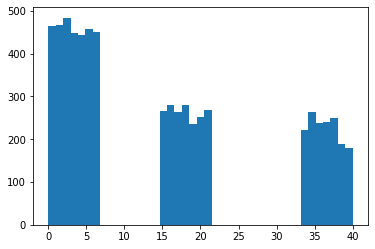

In [6]:
plt.hist(df["date"], bins= 41)

En observant la distribution des valeurs il semble clair que celle-ci que des intervalles de dates ont été volontairement retirés du set de test. Nous allons donc tenter d'approximer la distribution de ces valeurs estimant le nombre de réservations à partir de la date dans le but de l'utiliser pour notre stratégie de reqûetage de l'API.

Fitting 5 distributions: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.239915,858.239828,-67934.684545,inf,0.258940,0.000000e+00
burr,0.249705,864.627222,-67660.135711,inf,0.197549,1.106177e-227
beta,0.258416,828.970049,-67432.313491,inf,0.307845,0.000000e+00
lognorm,0.273260,1213.927192,-67070.037150,inf,0.425777,0.000000e+00
norm,0.281189,794.774907,-66888.797458,inf,0.231701,4.208041e-314


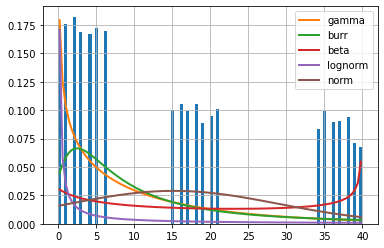

In [7]:
dates = df["date"].values
f = Fitter(dates, distributions=['gamma', 'lognorm', "beta", "burr", "norm"])
f.fit()
f.summary()

On peut voir ici que les valeurs manquantes nous empêchent de prédire correctement la distribution des données. On va donc tester différentes techniques de data imputation pour régler ce problème.